In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
  
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
ratings = pd.read_csv("C:\\Users\\syed mubarak pasha\\OneDrive\\Documents\\Python\\Assignment\\Recommendation\\recommend\\ratings.csv")
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
movies = pd.read_csv("C:\\Users\\syed mubarak pasha\\OneDrive\\Documents\\Python\\Assignment\\Recommendation\\recommend\\movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
data = pd.merge(ratings, movies, on='movieId')
data.head()

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [5]:
data.groupby('title')['rating'].mean().sort_values(ascending=False).head()

title
Gena the Crocodile (1969)              5.0
True Stories (1986)                    5.0
Cosmic Scrat-tastrophe (2015)          5.0
Love and Pigeons (1985)                5.0
Red Sorghum (Hong gao liang) (1987)    5.0
Name: rating, dtype: float64

In [6]:
data.groupby('title')['rating'].count().sort_values(ascending=False).head()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
Name: rating, dtype: int64

In [7]:
ratings = pd.DataFrame(data.groupby('title')['rating'].mean())
 
ratings['num of ratings'] = pd.DataFrame(data.groupby('title')['rating'].count())
 
ratings.head()

,rating,num of ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


<AxesSubplot:xlabel='rating', ylabel='Density'>

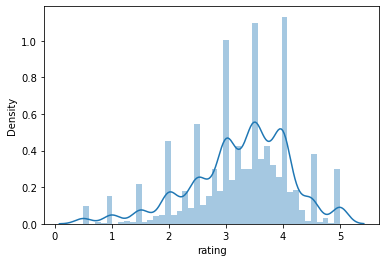

In [8]:
sns.distplot(ratings['rating'])

<AxesSubplot:xlabel='num of ratings', ylabel='Density'>

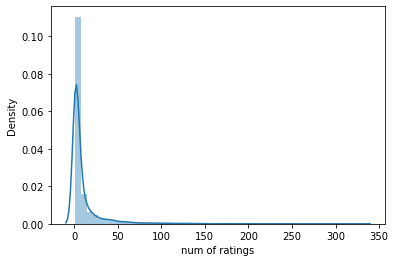

In [9]:
sns.distplot(ratings['num of ratings'])

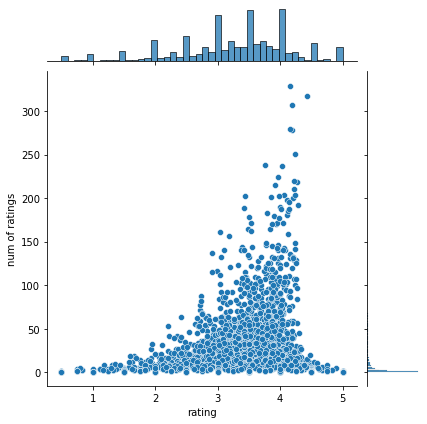

In [10]:
sns.jointplot(x=ratings['rating'],y=ratings['num of ratings'])

In [11]:
n_ratings = len(data)
n_movies = len(data['movieId'].unique())
n_users = len(data['userId'].unique())

In [12]:
print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieId's: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieId's: 9724
Number of unique users: 610
Average ratings per user: 165.3
Average ratings per movie: 10.37


In [13]:
user_freq = data[['userId', 'movieId']].groupby('userId').count().reset_index()
user_freq.columns = ['userId', 'n_ratings']
user_freq.head()

,userId,n_ratings
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [14]:
mean_data = data.groupby('movieId')[['rating']].mean()

In [15]:
# Lowest rated movies
lowest_rated = mean_data['rating'].idxmin()
movies.loc[movies['movieId'] == lowest_rated]

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [16]:
# Highest rated movies
highest_rated = mean_data['rating'].idxmax()
movies.loc[movies['movieId'] == highest_rated]

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


In [17]:
# show number of people who rated movies rated movie highest
data[data['movieId']==highest_rated]

,userId,movieId,rating,timestamp,title,genres
86227,85,53,5.0,889468268,Lamerica (1994),Adventure|Drama
86228,603,53,5.0,963180003,Lamerica (1994),Adventure|Drama


In [18]:
# show number of people who rated movies rated movie lowest
data[data['movieId']==lowest_rated]

,userId,movieId,rating,timestamp,title,genres
86372,89,3604,0.5,1520408880,Gypsy (1962),Musical


In [19]:
def create_matrix(df): 
    N = len(df['userId'].unique())
    M = len(df['movieId'].unique())
    user_mapper = dict(zip(np.unique(df["userId"]), list(range(N))))
    movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(M))))
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["userId"])))
    movie_inv_mapper = dict(zip(list(range(M)), np.unique(df["movieId"])))
      
    user_index = [user_mapper[i] for i in df['userId']]
    movie_index = [movie_mapper[i] for i in df['movieId']]
  
    X = csr_matrix((df["rating"], (movie_index, user_index)), shape=(M, N))
      
    return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper
X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_matrix(data)

In [20]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, k, metric='cosine', show_distance=False):
      
    neighbour_ids = []
      
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    movie_vec = movie_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(movie_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [21]:
movie_titles = dict(zip(movies['movieId'], movies['title']))
movie_id = 3
  
similar_ids = find_similar_movies(movie_id, X, k=10)
movie_title = movie_titles[movie_id]
  
print(f"Since you watched {movie_title}")
for i in similar_ids:
    print(movie_titles[i])

Since you watched Grumpier Old Men (1995)
Grumpy Old Men (1993)
Striptease (1996)
Nutty Professor, The (1996)
Twister (1996)
Father of the Bride Part II (1995)
Broken Arrow (1996)
Bio-Dome (1996)
Truth About Cats & Dogs, The (1996)
Sabrina (1995)
Birdcage, The (1996)


In [22]:
def discretise(List, Step):
    D_List = []
    MIN = min(List)
    MAX = max(List)
    NumOfStates = (MAX-MIN)/Step
    
    for items in List:
        D_List.append(int(items/Step))
        
    #if(NumOfStates == max(D_List)):
    return D_List

In [ ]:
print(discretise(data['userId'], 100))
data['userId']= discretise(data['userId'], 100)

In [ ]:
print(discretise(data['rating'], 1))
data['rating']= discretise(data['rating'], 1)

In [25]:
data.head()

,userId,movieId,rating,timestamp,title,genres
0,0,1,4,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,0,1,4,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,0,1,4,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,0,1,2,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,0,1,4,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [26]:
features = list(data.columns[:1])
features

['userId']

In [27]:
from sklearn import tree
X = data[features]
y = data["rating"]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X,y)

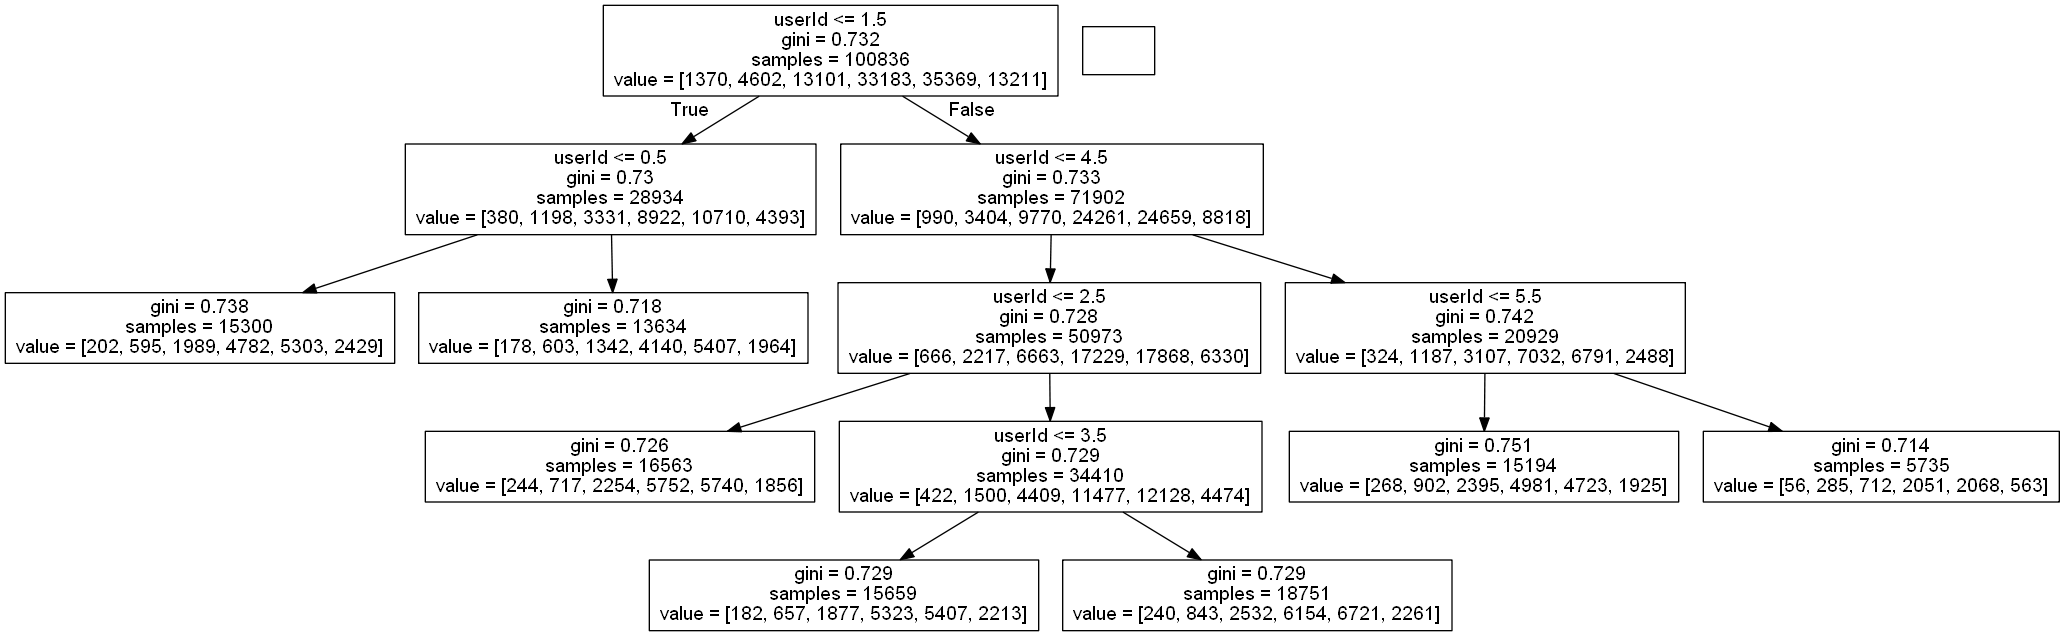

In [28]:
from IPython.display import Image  
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
import pydotplus
from sklearn import tree

dot_data = StringIO()  
tree.export_graphviz(clf, out_file=dot_data,  
                         feature_names=features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

Image(graph.create_png()) 

In [29]:
ratings_counts=ratings['rating'].value_counts()
ratings_counts

4.000000    1008
3.000000     916
3.500000     910
2.500000     520
2.000000     443
            ... 
3.701299       1
3.518182       1
3.953488       1
3.494382       1
3.890625       1
Name: rating, Length: 1287, dtype: int64